# Notebook to demonstrate minimal working example of rotating $u,v$ velocities from their native $\xi,\eta$ coordinates to east-west and north-south for ROMS output.
### See https://www.myroms.org/forum/viewtopic.php?f=3&t=295 for more information

In [1]:
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
import matplotlib.pyplot as plt 
import glob

In [2]:
path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
ds_avg = xroms.open_mfnetcdf(path)
ds_avg, grid_avg = xroms.roms_dataset(ds_avg)

In [3]:
ds_avg.u

<xarray.DataArray 'u' (ocean_time: 1080, s_rho: 30, eta_rho: 191, xi_u: 670)>
dask.array<concatenate, shape=(1080, 30, 191, 670), dtype=float32, chunksize=(1, 30, 191, 670), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_u       (eta_rho, xi_u) float64 dask.array<chunksize=(191, 670), meta=np.ndarray>
    lat_u       (eta_rho, xi_u) float64 dask.array<chunksize=(191, 670), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2010-06-02T18:30:00 ... 2010-07-1...
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 ... 662 663 664 665 666 667 668 669
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 184 185 186 187 188 189 190
    z_rho_u     (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 30, 191, 670), meta=np.ndarray>
    z_rho_u0    (s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(30, 191, 670), meta=np.ndarray>
Attributes:
    long_name:  time-averaged u-momentum component
    units:      meter second-1
    time:       ocean_time
    grid:       <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * cente...
    location:   edge1
    field:      u-velocity, scalar, series

# Rotate to east-west
### u(LON,LAT)=u(XI,ETA)*cos(angle(i,j))-v(XI,ETA)*sin(angle(i,j))
### v(LON,LAT)=v(XI,ETA)*cos(angle(i,j))+u(XI,ETA)*sin(angle(i,j))

In [4]:
ds_avg.angle

<xarray.DataArray 'angle' (eta_rho: 191, xi_rho: 671)>
dask.array<open_dataset-f1aad47ce2ff2cf5cae062ce14b5a8ddangle, shape=(191, 671), dtype=float64, chunksize=(191, 671), chunktype=numpy.ndarray>
Coordinates:
    lon_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lat_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 663 664 665 666 667 668 669 670
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 7 ... 183 184 185 186 187 188 189 190
Attributes:
    long_name:  angle between XI-axis and EAST
    units:      radians
    grid:       <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * cente...
    location:   face
    field:      angle, scalar

# We need to interpolate the (u,v) velocities to the rho points because they are not on the cell centers and .angle is. 

In [5]:
u_rho = grid_avg.interp(ds_avg.u, 'X', boundary = 'extend') #boundary = extend is a no gradient condition
v_rho = grid_avg.interp(ds_avg.v, 'Y', boundary = 'extend')

u_ew = u_rho*np.cos(ds_avg.angle)-(v_rho*np.sin(ds_avg.angle)) #East-west
v_ns = v_rho*np.cos(ds_avg.angle)+(u_rho*np.sin(ds_avg.angle)) #North-south

# Plot a random model cross section to see how they differ 

Text(0.5, 1.0, 'u-velocity (east,west) [m/s]')

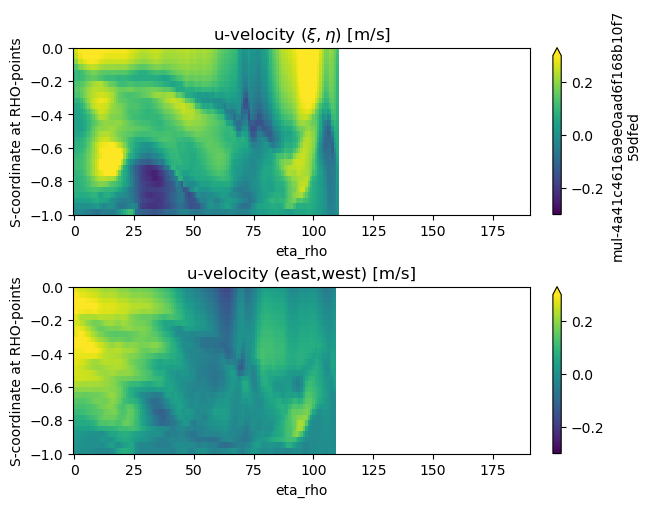

In [6]:
fig, ax = plt.subplots(2, constrained_layout = True)
u_rho[100,:,:,100].plot(x = 'eta_rho', ax = ax[0], vmin = -0.3, vmax = 0.3)
u_ew[100,:,:,100].plot(x = 'eta_rho', ax = ax[1], vmin = -0.3, vmax = 0.3)

ax[0].set_title(r'u-velocity ($\xi,\eta$) [m/s]')
ax[1].set_title(r'u-velocity (east,west) [m/s]')

Text(0.5, 1.0, 'v-velocity (north,south) [m/s]')

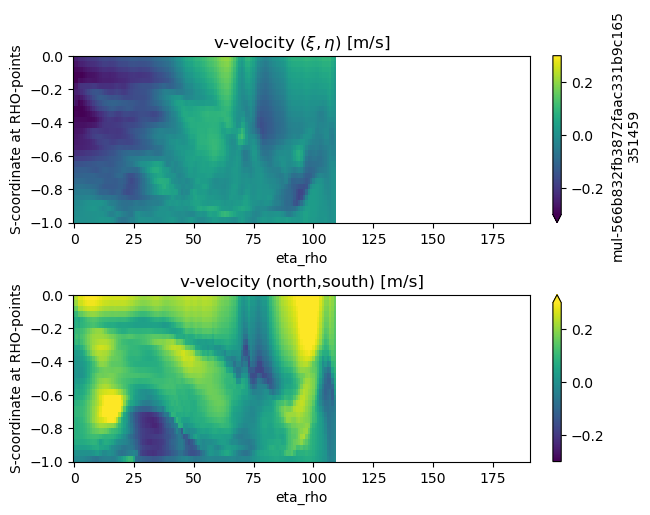

In [7]:
fig, ax = plt.subplots(2, constrained_layout = True)
v_rho[100,:,:,100].plot(x = 'eta_rho', ax = ax[0], vmin = -0.3, vmax = 0.3)
v_ns[100,:,:,100].plot(x = 'eta_rho', ax = ax[1], vmin = -0.3, vmax = 0.3)

ax[0].set_title(r'v-velocity ($\xi,\eta$) [m/s]')
ax[1].set_title(r'v-velocity (north,south) [m/s]')

## Wilkin from the ROMS thread also recommends computing the transformation as:
#### uveitheta = (u_roms+1i*v_roms).*exp(1i*angle); % 1i = sqrt(-1) in Matlab
#### u_east = real(uveitheta);
#### v_north = imag(uveitheta);
Python - '1j' is the same thing as sqrt(-1)

In [8]:
#Translation 
uveitheta = (u_rho+1j*v_rho)*np.exp(1j*ds_avg.angle)
u_east = uveitheta.real;
v_north = uveitheta.imag;

## Compare our method to what wilkin suggests - they should yield the same answer 

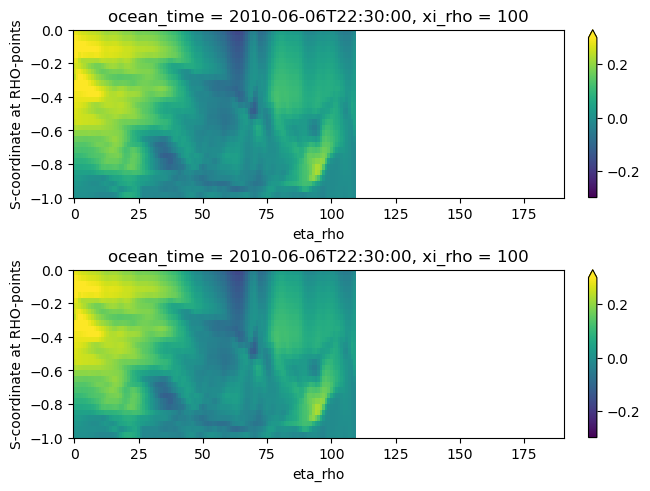

In [9]:
fig, ax = plt.subplots(2, constrained_layout = True)
u_ew[100,:,:,100].plot(x = 'eta_rho', ax = ax[0], vmin = -0.3, vmax = 0.3)
u_east[100,:,:,100].plot(x = 'eta_rho', ax = ax[1], vmin = -0.3, vmax = 0.3)

In [10]:
u_ew[100,:,:,100].values-u_east[100,:,:,100].values

array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan]])

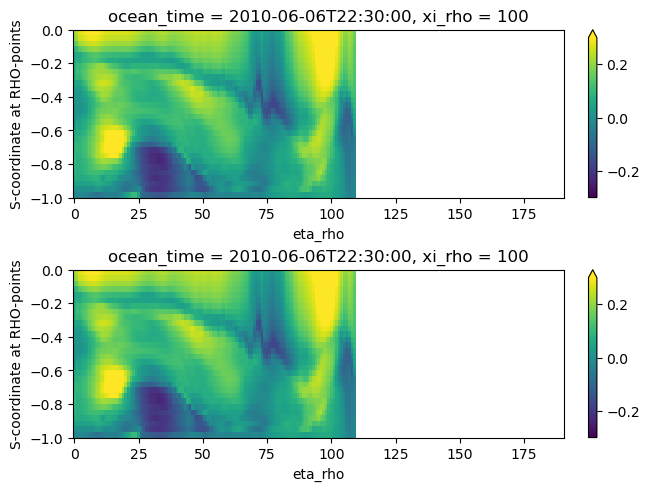

In [11]:
fig, ax = plt.subplots(2, constrained_layout = True)
v_ns[100,:,:,100].plot(x = 'eta_rho', ax = ax[0], vmin = -0.3, vmax = 0.3)
v_north[100,:,:,100].plot(x = 'eta_rho', ax = ax[1], vmin = -0.3, vmax = 0.3)

In [12]:
v_ns[100,:,:,100].values-v_north[100,:,:,100].values

array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan]])

# Conclusion - both methods work as expected 